In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from aif360.datasets import StandardDataset
from aif360.metrics import DatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric
from aif360.algorithms.inprocessing import AdversarialDebiasing

# Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split

#Tensorflow -- install version before 2.0
import tensorflow as tf 

from IPython.display import Markdown, display

In [2]:
data = pd.read_csv('../bank-additional/bank-additional-full.csv', sep=';' )

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
data['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [6]:
#Drop duration because of leakage explained in dataset website.
data = data.drop(labels=['duration'], axis=1)


In [7]:
len(data['age'].unique())

78

(array([3.300e+01, 4.200e+01, 6.500e+01, 1.020e+02, 1.370e+02, 2.260e+02,
        4.630e+02, 5.980e+02, 6.980e+02, 8.510e+02, 1.001e+03, 1.453e+03,
        1.714e+03, 1.947e+03, 1.846e+03, 1.833e+03, 1.745e+03, 1.759e+03,
        1.780e+03, 1.475e+03, 1.407e+03, 1.432e+03, 1.161e+03, 1.278e+03,
        1.142e+03, 1.055e+03, 2.114e+03, 1.030e+03, 9.280e+02, 9.790e+02,
        8.390e+02, 8.750e+02, 7.540e+02, 7.790e+02, 7.330e+02, 6.840e+02,
        6.480e+02, 7.040e+02, 6.460e+02, 5.760e+02, 4.630e+02, 2.830e+02,
        7.300e+01, 6.200e+01, 5.500e+01, 5.700e+01, 4.400e+01, 5.700e+01,
        2.600e+01, 3.300e+01, 3.400e+01, 4.700e+01, 8.700e+01, 3.400e+01,
        3.200e+01, 2.400e+01, 3.400e+01, 2.000e+01, 2.700e+01, 1.400e+01,
        3.100e+01, 2.000e+01, 1.700e+01, 1.700e+01, 7.000e+00, 1.500e+01,
        8.000e+00, 1.000e+00, 2.200e+01, 2.000e+00, 0.000e+00, 2.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([17.        , 18.03846154, 19

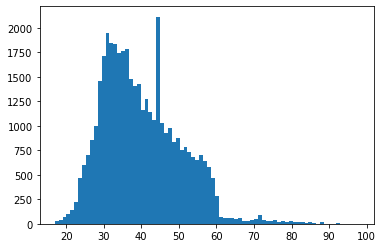

In [8]:
plt.hist(data['age'], bins=78)

In [9]:
data['y'] = data['y'].transform(lambda x: 1 if x == 'yes' else 0)

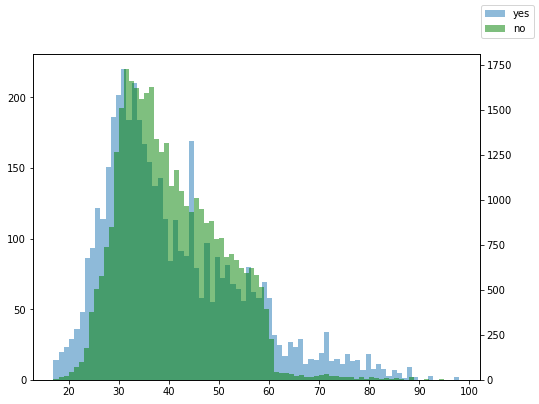

In [10]:
yes_data = data[data['y']==1]

no_data = data[data['y']==0]

fig, ax = plt.subplots(figsize=(8,6))

ax.hist(yes_data['age'], bins=78, alpha=.5, label='yes')

ax2 = ax.twinx()
ax2.hist(no_data['age'], bins=78, alpha=.5, label='no', color='green')

fig.legend()


In [11]:
no_data['education'].value_counts() / len(no_data['education'])


university.degree      0.287239
high.school            0.232133
basic.9y               0.152457
professional.course    0.127175
basic.4y               0.102550
basic.6y               0.057568
unknown                0.040495
illiterate             0.000383
Name: education, dtype: float64

In [12]:
yes_data['education'].value_counts()/ len(yes_data['education'])

university.degree      0.359914
high.school            0.222198
professional.course    0.128233
basic.9y               0.101940
basic.4y               0.092241
unknown                0.054095
basic.6y               0.040517
illiterate             0.000862
Name: education, dtype: float64

In [13]:
data['education'] = data['education'].transform(lambda x: 1 if x =='university.degree' or x=='professional.course' else 0)

In [14]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,0,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,0,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,0,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,0,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,0,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [15]:
u = [{'education': 0}]
p = [{'education': 1}]

In [16]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [17]:
sd_ed = StandardDataset(df=data,   
                         label_name='y',
                         favorable_classes =[1],
                        protected_attribute_names=['education'], 
                         privileged_classes=[[1]],
                        categorical_features=['job', 'marital', 'default', 'housing', 'loan','contact', 'month', 'day_of_week', 'poutcome'])



In [18]:
df_ed = sd_ed.convert_to_dataframe()

In [19]:
#age
#bl_age = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_age[0], label_names=['y'],
 #                   protected_attribute_names=['age'])

In [20]:
bl_ed = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_ed[0], label_names=['y'],
              protected_attribute_names=['education'])

In [21]:
data_train, data_vt = bl_ed.split([0.7], shuffle=True)

data_val, data_test = data_vt.split([0.5], shuffle=True)

In [46]:
metric_train = BinaryLabelDatasetMetric(data_train, 
                            unprivileged_groups=u, 
                            privileged_groups=p)
#Explainer! 
ex_metric_train = MetricTextExplainer(metric_train)

print(ex_metric_train.mean_difference())
print(ex_metric_train.disparate_impact())



Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.028721307658736664
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.7787456343978083


## Random Forest Classifer 

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [27]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=5)

df_train = data_train.convert_to_dataframe()[0]

X_train = df_train.values[:,:-1]

y_train = df_train.values[:,-1]

df_val = data_val.convert_to_dataframe()[0]
X_test = df_val.values[:,:-1]
y_test = df_val.values[:,-1]

In [32]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
y_pred = rfc.predict(X_test)

In [34]:
rfc.score(X_test, y_test)

0.9030430560051796

In [35]:
data_val_pred = data_val.copy()

data_val_pred.labels = y_pred

In [39]:
metric_preds = BinaryLabelDatasetMetric(data_val_pred, 
                            unprivileged_groups=u, 
                            privileged_groups=p)

print(metric_preds.mean_difference())
print(metric_preds.disparate_impact())

-0.01376187628208109
0.601058497556116


In [36]:
metric = ClassificationMetric(data_val, data_val_pred, 
                            unprivileged_groups=u, 
                            privileged_groups=p)

In [37]:
aod = metric.average_odds_difference()

eod = metric.equal_opportunity_difference()

ti = metric.theil_index()

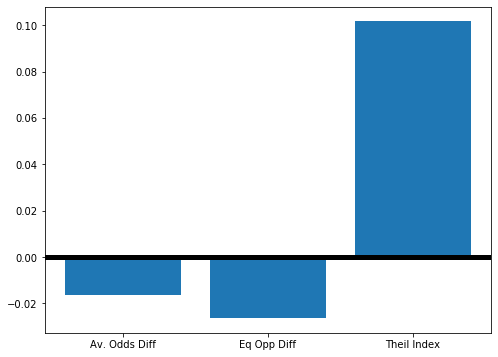

In [38]:
metric_list = [aod,eod,ti]
tick_list = ['Av. Odds Diff', 'Eq Opp Diff', 'Theil Index']
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(range(len(tick_list)), metric_list)
ax.set_xticks([0,1,2])
ax.set_xticklabels(tick_list)
ax.axhline(0, color='black', lw=5)

## Reweighing

In [49]:
RW = Reweighing(unprivileged_groups=u, 
               privileged_groups=p)

data_transf_train = RW.fit_transform(data_train)

data_transf_train.instance_weights

data_transf_val = RW.fit_transform(data_val)

In [53]:
metric_transf_train = BinaryLabelDatasetMetric(data_transf_train, 
                                             unprivileged_groups=u, 
                                            privileged_groups=p)

In [54]:
metric_transf_train.mean_difference()

2.7755575615628914e-17

In [55]:
rfc_rw = RandomForestClassifier(n_estimators=500, max_depth=5)

X_tr_train = data_transf_train.features

y_tr_train = data_transf_train.labels.ravel()

X_tr_test = data_transf_val.features
y_tr_test = data_transf_val.labels


rfc_rw.fit(X_tr_train, y_tr_train, sample_weight=data_transf_train.instance_weights)

In [60]:
y_tr_pred = rfc_rw.predict(X_tr_test)

In [61]:
data_val_tr_pred = data_transf_val.copy()
data_val_tr_pred.labels = y_tr_pred

In [62]:
metric_tf = ClassificationMetric(data_transf_val, data_val_tr_pred, 
                            unprivileged_groups=u, 
                            privileged_groups=p)

ex_metric_tf = MetricTextExplainer(metric_tf)
print(ex_metric_tf.average_odds_difference())
print(ex_metric_tf.equal_opportunity_difference())
print(ex_metric_tf.theil_index())

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.023327284906835333
True positive rate difference (true positive rate on unprivileged instances - true positive rate on privileged instances): -0.04176730022051872
Theil index (generalized entropy index with alpha = 1): 0.0976792122323697


In [53]:
aod_tr = metric_tf.average_odds_difference()

eod_tr = metric_tf.equal_opportunity_difference()

ti_tr = metric_tf.theil_index()

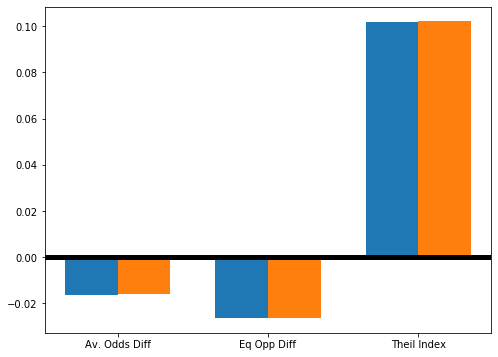

In [54]:
metric_list = [aod,eod,ti]
metric_tr_list= [aod_tr, eod_tr, ti_tr]
ind = np.arange(len(metric_list))
width = 0.35
tick_list = ['Av. Odds Diff', 'Eq Opp Diff', 'Theil Index']
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(ind-width/2, metric_list, width)
ax.bar(ind+width/2, metric_tr_list, width)
ax.set_xticks([0,1,2])
ax.set_xticklabels(tick_list)
ax.axhline(0, color='black', lw=5)

### Adverserial Debiasing

In [55]:
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow as tf


//anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [56]:
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = p,
                          unprivileged_groups = u,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

In [57]:
plain_model.fit(data_train) 




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 58.795753
epoch 0; iter: 200; batch classifier loss: 14.487020
epoch 1; iter: 0; batch classifier loss: 12.348308
epoch 1; iter: 200; batch classifier loss: 1.921310
epoch 2; iter: 0; batch classifier loss: 1.306221
epoch 2; iter: 200; batch classifier loss: 0.284668
epoch 3; iter: 0; batch classifier loss: 0.403237
epoch 3; iter: 200; batch classifier loss: 0.628210
epoch 4;

In [60]:
dataset_nodebiasing_train = plain_model.predict(data_train)
dataset_nodebiasing_test = plain_model.predict(data_val)

In [66]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=u,
                                             privileged_groups=p)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=u,
                                             privileged_groups=p)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(data_val, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=u,
                                                 privileged_groups=p)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.011153
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.009183


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.893655
Test set: Balanced classification accuracy = 0.551516
Test set: Disparate impact = 0.549154
Test set: Equal opportunity difference = -0.016521
Test set: Average odds difference = -0.010522
Test set: Theil_index = 0.110539


### Debiasing

In [68]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [69]:
debiased_model = AdversarialDebiasing(privileged_groups = p,
                          unprivileged_groups = u,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [70]:

debiased_model.fit(data_train)

epoch 0; iter: 0; batch classifier loss: 50.281715; batch adversarial loss: 0.717845
epoch 0; iter: 200; batch classifier loss: 3.902729; batch adversarial loss: 0.685226
epoch 1; iter: 0; batch classifier loss: 5.783326; batch adversarial loss: 0.678673
epoch 1; iter: 200; batch classifier loss: 0.637712; batch adversarial loss: 0.676483
epoch 2; iter: 0; batch classifier loss: 0.475482; batch adversarial loss: 0.690023
epoch 2; iter: 200; batch classifier loss: 0.679652; batch adversarial loss: 0.675735
epoch 3; iter: 0; batch classifier loss: 0.564595; batch adversarial loss: 0.676557
epoch 3; iter: 200; batch classifier loss: 0.409397; batch adversarial loss: 0.659905
epoch 4; iter: 0; batch classifier loss: 0.443260; batch adversarial loss: 0.681696
epoch 4; iter: 200; batch classifier loss: 0.307216; batch adversarial loss: 0.698528
epoch 5; iter: 0; batch classifier loss: 0.315358; batch adversarial loss: 0.683182
epoch 5; iter: 200; batch classifier loss: 0.331659; batch advers

In [72]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(data_train)
dataset_debiasing_test = debiased_model.predict(data_val)

In [73]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=u,
                                             privileged_groups=p)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=u,
                                             privileged_groups=p)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(data_val, 
                                                 dataset_debiasing_test,
                                                    unprivileged_groups=u,
                                                 privileged_groups=p)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())
                                                        
                                                        
                                                        
                                                        
                                                        

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.011153
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.009183


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.013209
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.012286


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.893655
Test set: Balanced classification accuracy = 0.551516
Test set: Disparate impact = 0.549154
Test set: Equal opportunity difference = -0.016521
Test set: Average odds difference = -0.010522
Test set: Theil_index = 0.110539


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.897702
Test set: Balanced classification accuracy = 0.588998
Test set: Disparate impact = 0.666993
Test set: Equal opportunity difference = -0.031776
Test set: Average odds difference = -0.017541
Test set: Theil_index = 0.102324
